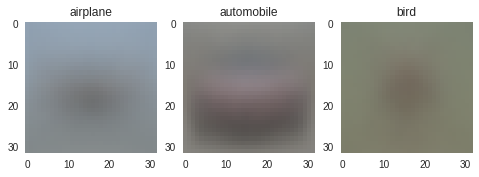

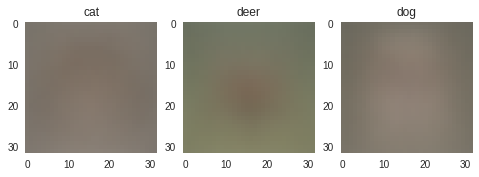

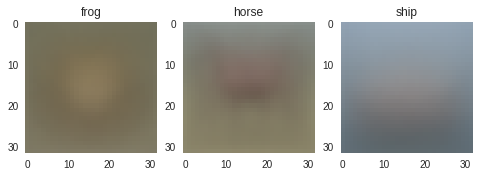

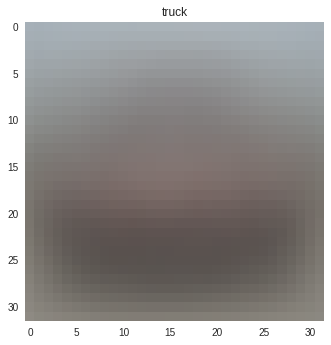

In [22]:
import pickle
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import paired_distances
import csv
import matplotlib.pyplot as plt

def unpickle(file):
  with open(file, 'rb') as fo:
    dict = pickle.load(fo, encoding='bytes')
  return dict

#Read Data
d1 = unpickle('../content/data_batch_1')
d2 = unpickle('../content/data_batch_2')
d3 = unpickle('../content/data_batch_3')
d4 = unpickle('../content/data_batch_4')
d5 = unpickle('../content/data_batch_5')
d6 = unpickle('../content/test_batch')
meta = unpickle('../content/batches.meta')


#Build the data and lable arrays
labels = d1[b'labels']
labels = np.append(labels,d2[b'labels'])
labels = np.append(labels,d3[b'labels'])
labels = np.append(labels,d4[b'labels'])
labels = np.append(labels,d5[b'labels'])
labels = np.append(labels,d6[b'labels'])

data = d1[b'data']
data = np.append(data,d2[b'data'], axis=0)
data = np.append(data,d3[b'data'],axis=0)
data = np.append(data,d4[b'data'],axis=0)
data = np.append(data,d5[b'data'],axis=0)
data = np.append(data,d6[b'data'],axis=0)

label_names = meta[b'label_names']

for i in range(len(label_names)):
  label_names[i] = str(label_names[i])
  label_names[i] = label_names[i][2:len(label_names[i])-1]

#Split data as per labels
d = {}

for i in np.unique(labels):
  rownum = np.where(labels[:] == i)
  d[i] = data[rownum]

#Build Error matrix  
mean_image_x = np.empty((1,3072))
image_info_x = {}
err_x = np.empty((10,10))
l_avg_err_x = []
for i in d:
  pca = PCA(20)
  pca.fit(d[i])
  (wi, vi) = (pca.explained_variance_,pca.components_)

  for j in (d):
    
    if i == j:
      t_data_j = pca.transform(d[j])
      it_data_j = pca.inverse_transform(t_data_j)
      mean_image_x = np.append(mean_image_x,pca.mean_.reshape(1,3072), axis=0)
      ed_x = np.square(paired_distances(d[i],it_data_j))
      avg_error_x = np.mean(ed_x)
      l_avg_err_x.append(avg_error_x)
      
    else:
      mean_image_j = np.mean(d[j], axis=0).reshape(1,3072)
      it_data_j = mean_image_j + np.dot(np.dot((d[j]-mean_image_j), vi.T), vi) 
    err_x[j,i] = np.mean(np.square(paired_distances(d[j],it_data_j)))                      
  image_info_x[i] = (mean_image_x[i],t_data_j,d[i],it_data_j,ed_x, avg_error_x)


#get ED for part B (mean images)

mean_image_x = mean_image_x[1:,:]
mean_ed_x = euclidean_distances(mean_image_x,mean_image_x, squared = True)

#write part b file with ED values
with open("partb_distances.csv", "w") as csvfile:
    filewriter = csv.writer(csvfile, delimiter=",")
    filewriter.writerows(mean_ed_x)
    
#get ed vales for part C
err_c_x = np.empty((10,10))

for i in range(10):
  for j in range(10):
    err_c_x[i,j] = (err_x[i,j]+err_x[j,i])/2

#write csv file for part c
with open("partc_distances.csv", "w") as csvfile:
    filewriter = csv.writer(csvfile, delimiter=",")
    filewriter.writerows(err_c_x)
    


#print mean image here for each class: use mean_image

for i in range(10):
  array= np.asarray(mean_image_x[i])
  title = label_names[i]
  if i<9:
    if i%3 ==0:
      f, a= plt.subplots(1,3)
    a[i%3].grid(False)
    a[i%3].set_title(title)
    a[i%3].imshow(((array.reshape(3,1024).T).reshape(32,32,3))/255)
    if i%3 ==2:
      plt.show()
  else:
    f, a= plt.subplots()
    a.grid(False)
    a.set_title(title)
    a.imshow(((array.reshape(3,1024).T).reshape(32,32,3))/255)
    plt.show()



In [27]:
#Define MDS
def MDS(D):
  A = (np.identity(10) - (np.ones((10,10))/10))
  W = np.multiply(np.dot(np.dot(A,D),A.T),-.5)
  (w,v)= np.linalg.eig(W)
  idx = np.argsort(w)[::-1]
  v = v[:,idx]
  w = w[idx]
  
  v = v.T
  print(w)
  w = np.sqrt(w[:2])
  v = v[:2,:]
  w = np.diag(w)
  points = np.dot(v.T,w).T
  return(points)

#get avg error for bar chart
l_avg_err = []
for i in image_info_x:
  avg_error = image_info_x[i][5]
  l_avg_err.append(avg_error)

#get MDS for the scatter plot
px2= MDS(mean_ed_x)

px3 = MDS(err_c_x)


[ 6.15173893e+06  1.45406221e+06  5.21590924e+05  1.51038585e+05
  1.40266493e+05  4.31954908e+04  3.26951472e+04  2.88774729e+04
  1.32579007e+04 -4.35278567e-10]
[ 5.70988443e+05  3.44528916e+05  1.76938758e+05  1.03314507e+05
  7.19992001e+04  5.79851766e+04  4.65129781e+04  3.27392283e+04
  3.01024005e+04 -3.55810585e-11]


<function matplotlib.pyplot.show>

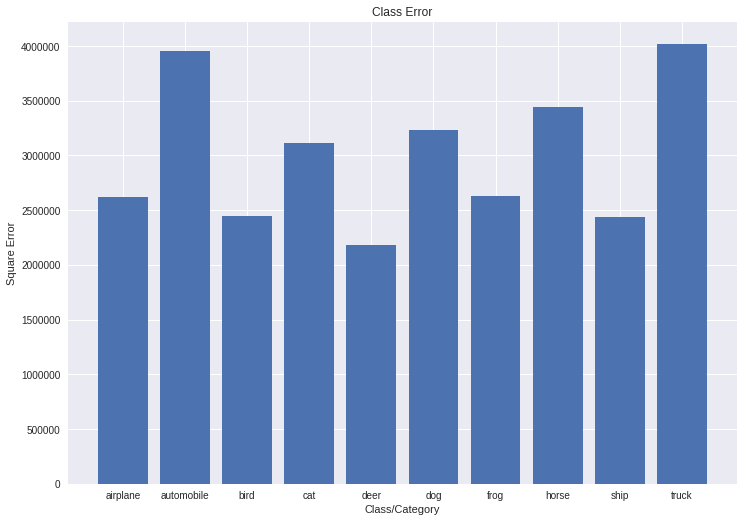

In [24]:
#Create a bar graph using image_info avg_error

f, a= plt.subplots()
f.set_size_inches(12, 8.5)

a.set_xlabel('Class/Category')
a.set_ylabel('Square Error')
a.set_title('Class Error')

plt.bar(np.unique(labels),l_avg_err,.8, tick_label =label_names )
plt.show

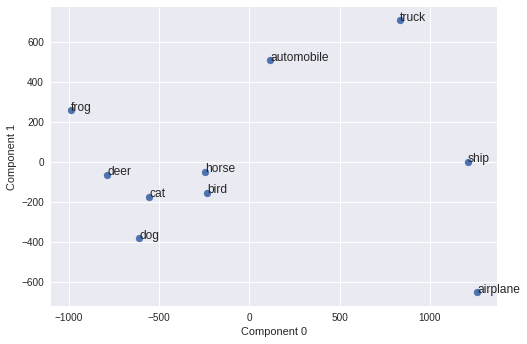

In [28]:
#print scatter plot B 
f, ax = plt.subplots()
ax.scatter(px2[0, :], px2[1, :])
ax.set_xlabel('Component 0')
ax.set_ylabel('Component 1')

for i in  range(len(label_names)):
  ax.annotate(label_names[i],(px2[0, i],px2[1, i]))

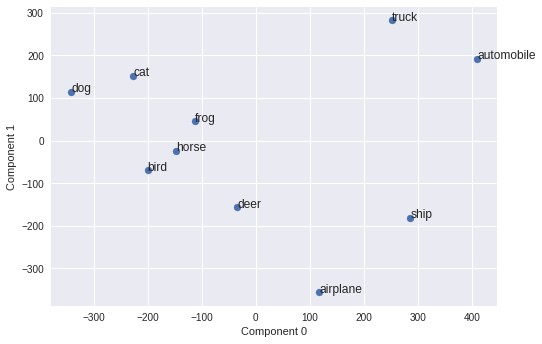

In [29]:
#print scatter plot C

f, ax = plt.subplots()
ax.scatter(px3[0, :], px3[1, :])
ax.set_xlabel('Component 0')
ax.set_ylabel('Component 1')


for i in  range(len(label_names)):
  ax.annotate(label_names[i],(px3[0, i],px3[1, i]))